#  Anomaly Detection for High-Energy Prompts (Unsupervised)

This notebook trains an **unsupervised anomaly detector** on model usage patterns
and flags **prompts/configurations with unusually high energy consumption**.

Goals:
- Learn "normal" usage using **Isolation Forest** (and optionally One-Class SVM).
- Flag outliers as potential high-energy anomalies.
- Provide simple **feature-based explanations** (e.g., high token count, high FLOPs/layer).


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import os
import joblib
# Change working directory 
os.chdir('C:\Conestoga Projects\CSCN8010_MLF\Sustainable_AI\data')

plt.rcParams["figure.figsize"] = (7, 5)
plt.rcParams["axes.grid"] = True


In [4]:
DATA_PATH = "energy_training_data.csv"  # or your synthetic 200-row CSV

df = pd.read_csv(DATA_PATH)
df.head()


,num_layers,training_hours,flops_per_hour,prompt_tokens,gpu_power_watts,batch_size,energy_kwh
0,21,3.036058,1.180361e+08,189,310.323046,77,2.857136
1,25,45.526522,4.491940e+07,270,277.679971,33,5.414321
2,10,30.477541,1.309254e+08,175,133.931910,145,5.114819
3,61,29.960245,1.338420e+08,511,305.704786,188,6.623944
4,32,18.246479,5.337145e+07,422,146.572406,38,4.476142


In [5]:
df = df.copy()

# Basic safety to avoid divide-by-zero
df["training_hours"] = df["training_hours"].replace(0, np.nan)
df["num_layers"] = df["num_layers"].replace(0, np.nan)

# Derived features
df["flops_per_layer"] = df["flops_per_hour"] / df["num_layers"]
df["energy_per_hour"] = df["energy_kwh"] / df["training_hours"]

if "prompt_tokens" in df.columns:
    df["energy_per_token"] = df["energy_kwh"] / df["prompt_tokens"].clip(lower=1)
else:
    df["energy_per_token"] = np.nan  # placeholder

# Replace infinities and NaNs with reasonable values
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(df.median(numeric_only=True), inplace=True)

df.head()


,num_layers,training_hours,flops_per_hour,prompt_tokens,gpu_power_watts,batch_size,energy_kwh,flops_per_layer,energy_per_hour,energy_per_token
0,21,3.036058,1.180361e+08,189,310.323046,77,2.857136,5.620765e+06,0.941067,0.015117
1,25,45.526522,4.491940e+07,270,277.679971,33,5.414321,1.796776e+06,0.118927,0.020053
2,10,30.477541,1.309254e+08,175,133.931910,145,5.114819,1.309254e+07,0.167823,0.029228
3,61,29.960245,1.338420e+08,511,305.704786,188,6.623944,2.194132e+06,0.221091,0.012963
4,32,18.246479,5.337145e+07,422,146.572406,38,4.476142,1.667858e+06,0.245315,0.010607


In [8]:
feature_cols = [
    "num_layers",
    "training_hours",
    "flops_per_hour",
    "flops_per_layer",
    "energy_kwh",
    "energy_per_hour",
]

if "prompt_tokens" in df.columns:
    feature_cols.append("prompt_tokens")
    feature_cols.append("energy_per_token")

X = df[feature_cols].values
feature_cols


['num_layers',
 'training_hours',
 'flops_per_hour',
 'flops_per_layer',
 'energy_kwh',
 'energy_per_hour',
 'prompt_tokens',
 'energy_per_token']

In [9]:
# Isolation Forest is robust for unsupervised anomaly detection
iso_forest = IsolationForest(
    n_estimators=200,
    contamination=0.05,  # expected fraction of anomalies, tune as needed
    random_state=2825
)

# Scale features + fit model in a pipeline
iso_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("iso", iso_forest),
])

iso_pipeline.fit(X)

# Compute anomaly scores and predictions
anomaly_scores = iso_pipeline["iso"].score_samples(iso_pipeline["scaler"].transform(X))
# In IsolationForest: lower scores -> more anomalous
pred_labels = iso_pipeline["iso"].predict(iso_pipeline["scaler"].transform(X))
# 1 = normal, -1 = anomaly

df["iso_score"] = anomaly_scores
df["iso_label"] = pred_labels


In [10]:
anomalies = df[df["iso_label"] == -1].copy()
print(f"Total anomalies flagged: {len(anomalies)}")

anomalies[feature_cols + ["iso_score"]].sort_values("iso_score").head(10)


Total anomalies flagged: 50


,num_layers,training_hours,flops_per_hour,flops_per_layer,energy_kwh,energy_per_hour,prompt_tokens,energy_per_token,iso_score
282,25,1.384566,1.294796e+08,5.179185e+06,3.322918,2.399970,8,0.415365,-0.639652
30,16,20.402338,1.651867e+08,1.032417e+07,5.679857,0.278392,7,0.811408,-0.636167
158,5,0.643696,1.403563e+08,2.807126e+07,3.169905,4.924536,243,0.013045,-0.635692
787,57,30.729825,1.851052e+08,3.247460e+06,5.481352,0.178372,7,0.783050,-0.626571
205,13,5.345387,9.388905e+07,7.222234e+06,2.314521,0.432994,5,0.462904,-0.619728
346,42,6.611888,1.636495e+08,3.896417e+06,3.548867,0.536740,5,0.709773,-0.616525
5,4,21.329423,1.775051e+08,4.437628e+07,4.518595,0.211848,584,0.007737,-0.613175
974,70,1.817518,1.946398e+08,2.780569e+06,6.431865,3.538817,238,0.027025,-0.602999
507,4,42.540277,1.533247e+08,3.833116e+07,8.002189,0.188109,468,0.017099,-0.601459
339,19,27.838615,8.145267e+07,4.286983e+06,4.493243,0.161403,6,0.748874,-0.600222


In [11]:
# Compute z-scores over the entire dataset
X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)
df_z = pd.DataFrame(X_scaled, columns=[f"z_{c}" for c in feature_cols])

df = pd.concat([df, df_z], axis=1)

def explain_anomaly(row, feature_cols, z_prefix="z_", z_threshold=2.0):
    reasons = []

    for col in feature_cols:
        z_col = f"{z_prefix}{col}"
        z_val = row[z_col]

        if abs(z_val) >= z_threshold:
            direction = "high" if z_val > 0 else "low"
            reasons.append(f"{direction} {col} (z={z_val:.1f})")

    # Add some specific summary rules
    if "prompt_tokens" in feature_cols and row.get("z_prompt_tokens", 0) > z_threshold:
        reasons.append("unusually large prompt (token count)")

    if "flops_per_layer" in feature_cols and row.get("z_flops_per_layer", 0) > z_threshold:
        reasons.append("high compute per layer (FLOPs/layer)")

    if "energy_per_token" in feature_cols and row.get("z_energy_per_token", 0) > z_threshold:
        reasons.append("very high energy per token")

    if not reasons:
        reasons.append("overall usage deviates from normal pattern")

    return "; ".join(reasons)

# Apply to anomalies
anomalies = df[df["iso_label"] == -1].copy()
anomalies["anomaly_explanation"] = anomalies.apply(
    lambda r: explain_anomaly(r, feature_cols), axis=1
)

anomalies[feature_cols + ["iso_score", "anomaly_explanation"]].head(10)


,num_layers,training_hours,flops_per_hour,flops_per_layer,energy_kwh,energy_per_hour,prompt_tokens,energy_per_token,iso_score,anomaly_explanation
5,4,21.329423,1.775051e+08,4.437628e+07,4.518595,0.211848,584,0.007737,-0.613175,high flops_per_layer (z=6.8); high compute per...
30,16,20.402338,1.651867e+08,1.032417e+07,5.679857,0.278392,7,0.811408,-0.636167,high energy_per_token (z=12.4); very high ener...
53,4,39.622965,1.536899e+08,3.842248e+07,5.241792,0.132292,170,0.030834,-0.565911,high flops_per_layer (z=5.8); high compute per...
69,12,12.942167,2.769108e+07,2.307590e+06,0.915378,0.070728,17,0.053846,-0.543259,low energy_kwh (z=-2.5)
70,33,4.955485,1.900012e+08,5.757613e+06,4.907864,0.990390,25,0.196315,-0.544123,high energy_per_token (z=2.6); very high energ...
77,43,38.125466,1.713340e+08,3.984511e+06,7.252373,0.190224,29,0.250082,-0.557230,high energy_per_token (z=3.5); very high energ...
117,4,20.449368,1.678581e+08,4.196453e+07,4.389517,0.214653,149,0.029460,-0.561808,high flops_per_layer (z=6.4); high compute per...
151,42,3.804256,7.828735e+07,1.863985e+06,2.333831,0.613479,9,0.259315,-0.570485,high energy_per_token (z=3.6); very high energ...
158,5,0.643696,1.403563e+08,2.807126e+07,3.169905,4.924536,243,0.013045,-0.635692,high flops_per_layer (z=4.0); high energy_per_...
176,41,0.920819,1.649445e+08,4.023036e+06,4.110753,4.464234,364,0.011293,-0.555137,high energy_per_hour (z=6.5)


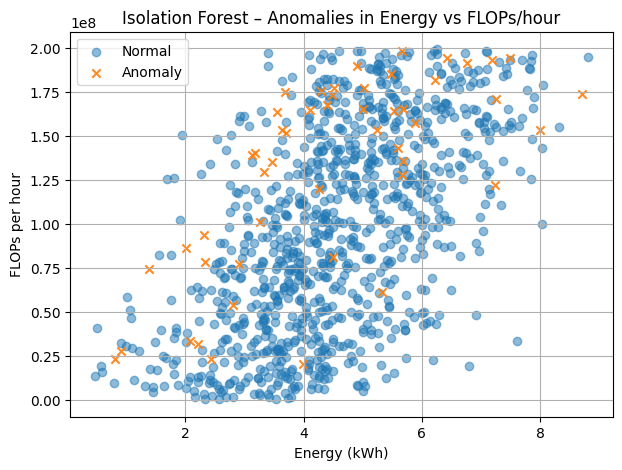

In [12]:
plt.figure()
normal = df[df["iso_label"] == 1]
anoms = df[df["iso_label"] == -1]

plt.scatter(
    normal["energy_kwh"],
    normal["flops_per_hour"],
    alpha=0.5,
    label="Normal"
)
plt.scatter(
    anoms["energy_kwh"],
    anoms["flops_per_hour"],
    alpha=0.9,
    marker="x",
    label="Anomaly"
)
plt.xlabel("Energy (kWh)")
plt.ylabel("FLOPs per hour")
plt.legend()
plt.title("Isolation Forest – Anomalies in Energy vs FLOPs/hour")
plt.show()


In [13]:
ocsvm_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("ocsvm", OneClassSVM(kernel="rbf", gamma="scale", nu=0.05))
])

ocsvm_pipeline.fit(X)

ocsvm_pred = ocsvm_pipeline["ocsvm"].predict(ocsvm_pipeline["scaler"].transform(X))
df["ocsvm_label"] = ocsvm_pred  # 1 = inlier, -1 = outlier

print("OC-SVM anomalies:", (df["ocsvm_label"] == -1).sum())


OC-SVM anomalies: 53


In [17]:
import joblib
import os

MODEL_DIR = os.path.join("model", "anomaly_detector")
os.makedirs(MODEL_DIR, exist_ok=True)

ANOMALY_MODEL_PATH = os.path.join(MODEL_DIR, "iso_pipeline.pkl")

# iso_pipeline must already be fitted at this point
joblib.dump(iso_pipeline, ANOMALY_MODEL_PATH)

print("Saved anomaly model to:", ANOMALY_MODEL_PATH)


Saved anomaly model to: model\anomaly_detector\iso_pipeline.pkl


In [14]:
def flag_anomalies(new_df: pd.DataFrame,
                   pipeline: Pipeline = iso_pipeline,
                   feature_cols=feature_cols,
                   z_threshold: float = 2.0) -> pd.DataFrame:
    """
    Given new usage records in a DataFrame with the same feature columns,
    returns a copy with anomaly flags and explanations.
    """
    temp = new_df.copy()

    # Recreate derived features as before
    if "flops_per_layer" in feature_cols and "flops_per_layer" not in temp.columns:
        temp["flops_per_layer"] = temp["flops_per_hour"] / temp["num_layers"]

    if "energy_per_hour" in feature_cols and "energy_per_hour" not in temp.columns:
        temp["energy_per_hour"] = temp["energy_kwh"] / temp["training_hours"]

    if "prompt_tokens" in feature_cols and "prompt_tokens" not in temp.columns:
        temp["prompt_tokens"] = np.nan

    if "energy_per_token" in feature_cols and "energy_per_token" not in temp.columns:
        temp["energy_per_token"] = temp["energy_kwh"] / temp["prompt_tokens"].clip(lower=1)

    # Replace infinities / NaNs
    temp.replace([np.inf, -np.inf], np.nan, inplace=True)
    temp.fillna(df.median(numeric_only=True), inplace=True)

    X_new = temp[feature_cols].values

    # Predict
    scores = pipeline["iso"].score_samples(pipeline["scaler"].transform(X_new))
    labels = pipeline["iso"].predict(pipeline["scaler"].transform(X_new))

    # z-scores for explanation (use training means/stds)
    X_all = df[feature_cols].values
    mean = X_all.mean(axis=0)
    std = X_all.std(axis=0)
    Xz_new = (X_new - mean) / std

    temp["iso_score"] = scores
    temp["iso_label"] = labels

    for i, col in enumerate(feature_cols):
        temp[f"z_{col}"] = Xz_new[:, i]

    temp["anomaly_explanation"] = temp.apply(
        lambda r: explain_anomaly(r, feature_cols, z_threshold=z_threshold), axis=1
    )

    return temp


In [16]:
test_row = df.sample(1, random_state=42)[feature_cols]
flagged = flag_anomalies(test_row)
flagged[feature_cols + ["iso_label", "iso_score", "anomaly_explanation"]]


,num_layers,training_hours,flops_per_hour,flops_per_layer,energy_kwh,energy_per_hour,prompt_tokens,energy_per_token,iso_label,iso_score,anomaly_explanation
521,37,23.788914,1.369199e+07,370053.741282,3.69294,0.155238,471,0.007841,1,-0.419904,overall usage deviates from normal pattern
